In [1]:
# Get rid of annoying tf warning
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
np.set_printoptions(suppress=True)

import bayesflow as beef
import tensorflow as tf

import sys
sys.path.append("../")
from experiments import SmoothingExperiment, FilteringExperiment
sys.path.append("../../../assets/")
from models import MixtureRandomWalkDDM

/Users/lukas/opt/miniconda3/envs/beef/lib/python3.11/site-packages/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [ ]:
# gpu setting and checking
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
print(tf.config.list_physical_devices('GPU'))

In [8]:
SIMULATE_VALIATION_DATA = False
FIT_MODEL = False
FIT_SBC = False

NUM_OBS = 800
NUM_SAMPLES = 1000
NUM_VALIDATION_SIMULATIONS = 500
NUM_SBC_SIMULATIONS = 1000
NUM_SBC_SAMPLES = 50

MICRO_PARAM_LABELS = ['Drift rate', 'Threshold', 'Non-decision time']
MICRO_PARAM_NAMES  = [r'$v$', r'$a$', r'$\tau$']
MACRO_PARAM_LABELS = ['Transition std. deviation', 'Switch Probability']
MACRO_PARAM_NAMES  = [r'$\sigma$', r'$q$']
COMPARISON_COLOR = '#133a76'

HYPER_PARAM_NAMES = [r'$\sigma_{v}$', r'$\sigma_{a}$', r'$\sigma_{\tau}$', r'$q_{v}$', r'$q_{a}$']
LOCAL_PARAM_NAMES = [r'$v$', r'$a$', r'$\tau$']

FONT_SIZE_1 = 18
FONT_SIZE_2 = 16
FONT_SIZE_3 = 14

FIG_SIZE = (18, 8)

In [3]:
model = MixtureRandomWalkDDM()
smoothing_experiment = SmoothingExperiment(model, "checkpoints/smoothing_summary_network")
filtering_experiment = FilteringExperiment(model, "checkpoints/filtering_summary_network")

INFO:root:Performing 2 pilot runs with the mixture_random_walk_ddm model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 800, 3)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 800)
INFO:root:Shape of hyper_prior_draws batch after 2 pilot simulations: (batch_size = 2, 5)
INFO:root:Shape of local_prior_draws batch after 2 pilot simulations: (batch_size = 2, 800, 3)
INFO:root:No shared_prior_draws provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional prior non-batchable context provided.
INFO:root:Loaded loss history from checkpoints/smoothing_summary_network/history_75.pkl.
INFO:root:Networks loaded from checkpoints/smoothing_summary_network/ckpt-75
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.
INFO:root:Loaded loss history fr

In [14]:
%%time
if SIMULATE_VALIATION_DATA:
    validation_data = model.generate(NUM_VALIDATION_SIMULATIONS)
    with open('../data/validation_data.pkl', 'wb') as f:
        pickle.dump(validation_data, f)
else:
    with open('../data/validation_data.pkl', 'rb') as f:
        validation_data = pickle.load(f)

CPU times: user 725 µs, sys: 6.56 ms, total: 7.28 ms
Wall time: 8.1 ms


In [22]:
validation_data.keys()

dict_keys(['sim_data', 'hyper_prior_draws', 'local_prior_draws', 'shared_prior_draws', 'sim_batchable_context', 'sim_non_batchable_context', 'prior_batchable_context', 'prior_non_batchable_context'])

In [23]:
true_hyper_params = validation_data['hyper_prior_draws']
true_local_params = validation_data['local_prior_draws']
true_local_params.shape

(500, 800, 3)

In [31]:
%%time
if FIT_MODEL:
    smoothing_post_hyper_params = np.zeros((NUM_VALIDATION_SIMULATIONS, NUM_SAMPLES, 5))
    smoothing_post_local_params = np.zeros((NUM_VALIDATION_SIMULATIONS, NUM_OBS, NUM_SAMPLES, 3))
    filtering_post_hyper_params = np.zeros((NUM_VALIDATION_SIMULATIONS, NUM_SAMPLES, 5))
    filtering_post_local_params = np.zeros((NUM_VALIDATION_SIMULATIONS, NUM_OBS, NUM_SAMPLES, 3))
    configured_val_data = model.configure(validation_data)['summary_conditions']
    for i in range(NUM_VALIDATION_SIMULATIONS):
        # fit smoothing network
        smoothing_post_samples = smoothing_experiment.amortizer.sample(
            {'summary_conditions': configured_val_data[i:i+1]},
            NUM_SAMPLES
            )
        smoothing_post_hyper_params[i] = smoothing_post_samples['global_samples']
        smoothing_post_local_params[i] = smoothing_post_samples['local_samples']
        # fit filtering network
        filtering_post_samples = filtering_experiment.amortizer.sample(
            {'summary_conditions': configured_val_data[i:i+1]},
            NUM_SAMPLES
            )
        filtering_post_hyper_params[i] = filtering_post_samples['global_samples']
        filtering_post_local_params[i] = filtering_post_samples['local_samples']
        
    with open('../data/smoothing_post_hyper_params.pkl', 'wb') as f:
        pickle.dump(smoothing_post_hyper_params, f)
    with open('../data/smoothing_post_local_params.pkl', 'wb') as f:
        pickle.dump(smoothing_post_local_params, f)
    with open('../data/filtering_post_hyper_params.pkl', 'wb') as f:
        pickle.dump(filtering_post_hyper_params, f)
    with open('../data/filtering_post_local_params.pkl', 'wb') as f:
        pickle.dump(filtering_post_local_params, f)
else:
    with open('../data/smoothing_post_hyper_params.pkl', 'rb') as f:
        smoothing_post_hyper_params = pickle.load(f)
    with open('../data/smoothing_post_local_params.pkl', 'rb') as f:
        smoothing_post_local_params = pickle.load(f)
    with open('../data/filtering_post_hyper_params.pkl', 'rb') as f:
        filtering_post_hyper_params = pickle.load(f)
    with open('../data/filtering_post_local_params.pkl', 'rb') as f:
        filtering_post_local_params = pickle.load(f)

CPU times: user 1.21 ms, sys: 3.6 s, total: 3.6 s
Wall time: 13.6 s


## Hyperparameter Recovery

### Smoothing

In [17]:
smoothing_post_hyper_params_not_z = smoothing_post_hyper_params * model.hyper_prior_std + model.hyper_prior_mean

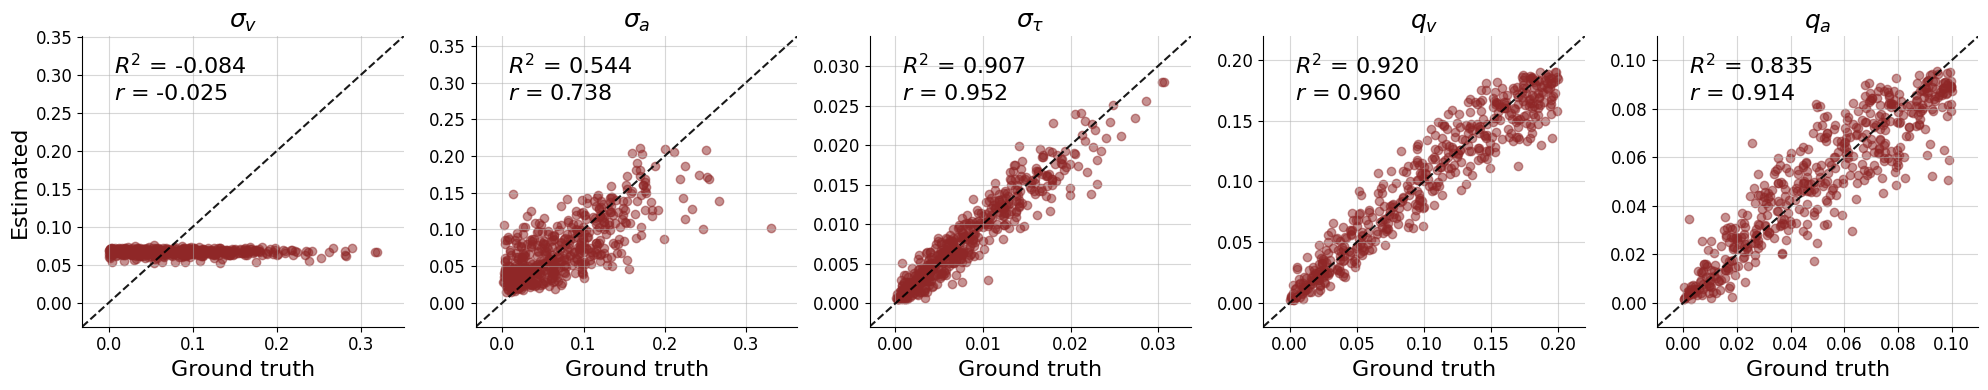

In [19]:
p = beef.diagnostics.plot_recovery(
    smoothing_post_hyper_params_not_z,
    true_hyper_params,
#     n_row=2,
    uncertainty_agg=None,
    param_names=HYPER_PARAM_NAMES
)

### Filtering

In [20]:
filtering_post_hyper_params_not_z = filtering_post_hyper_params * model.hyper_prior_std + model.hyper_prior_mean

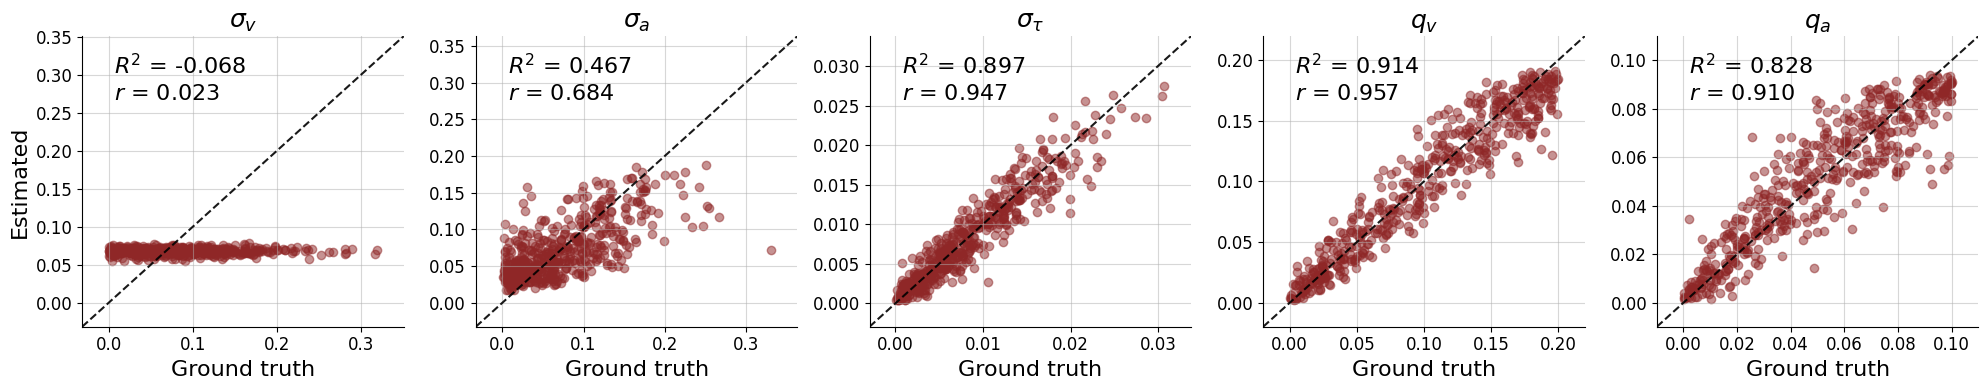

In [21]:
p = beef.diagnostics.plot_recovery(
    filtering_post_hyper_params_not_z,
    true_hyper_params,
#     n_row=2,
    uncertainty_agg=None,
    param_names=HYPER_PARAM_NAMES
)

## Local Parameter Recovery

In [46]:
time_steps = [0, 399, 799]

### Smoothing

In [32]:
smoothing_post_local_params_not_z = smoothing_post_local_params * model.local_prior_stds + model.local_prior_means

/var/folders/bv/vht4zx991wd5ygpm2yz12gd40000gn/T/ipykernel_36870/3274547007.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 1000x1200 with 0 Axes>

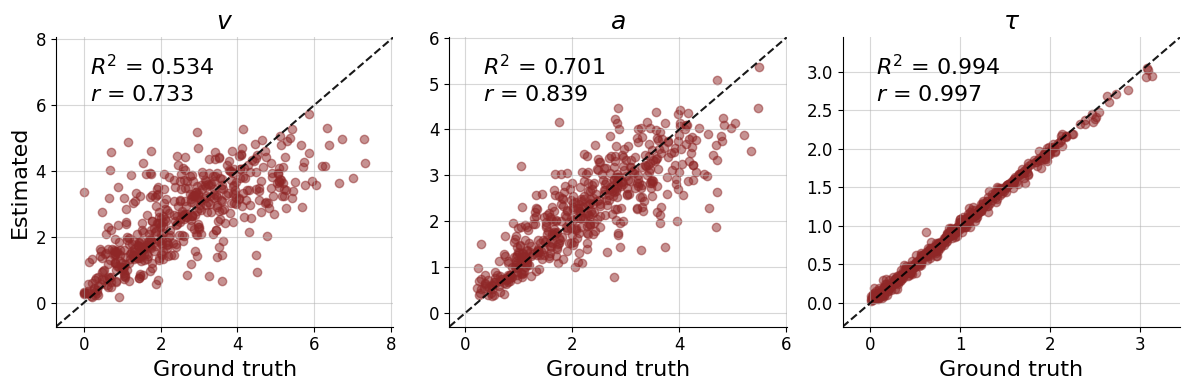

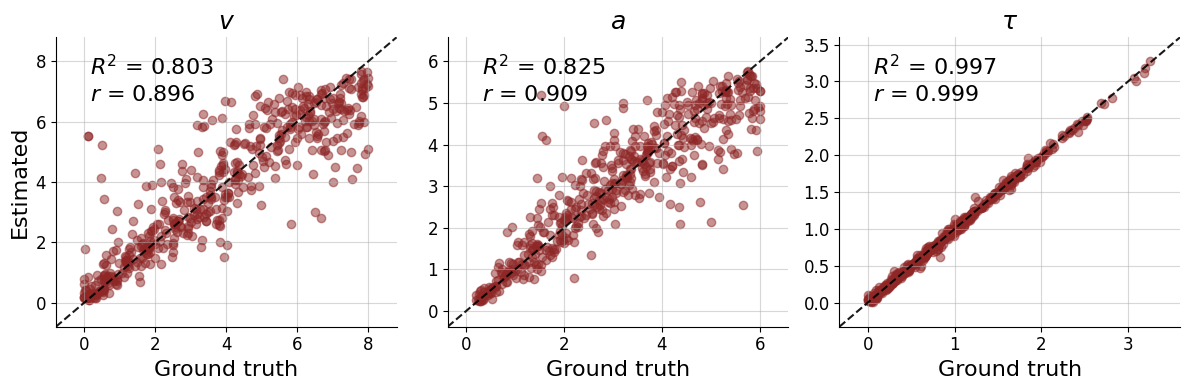

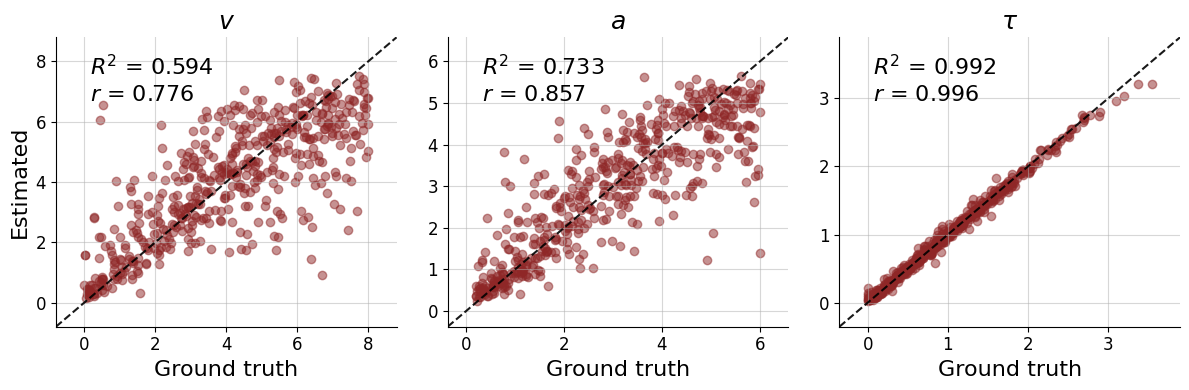

In [47]:
fig = plt.figure(constrained_layout=True, figsize=(10, 12))

# create 5x1 subfigs
subfigs = fig.subfigures(nrows=3, ncols=1)
for row, subfig in enumerate(subfigs):
    subfig.suptitle(f'T = {time_steps[row]}', fontsize=FONT_SIZE_1, fontweight='bold')

    axs = beef.diagnostics.plot_recovery(
        smoothing_post_local_params_not_z[:, time_steps[row]],
        true_local_params[:, time_steps[row]],
        uncertainty_agg=None,
        param_names=LOCAL_PARAM_NAMES
        )

fig.show()

### Filtering

In [33]:
filtering_post_local_params_not_z = filtering_post_local_params * model.local_prior_stds + model.local_prior_means

<Figure size 1000x1200 with 0 Axes>

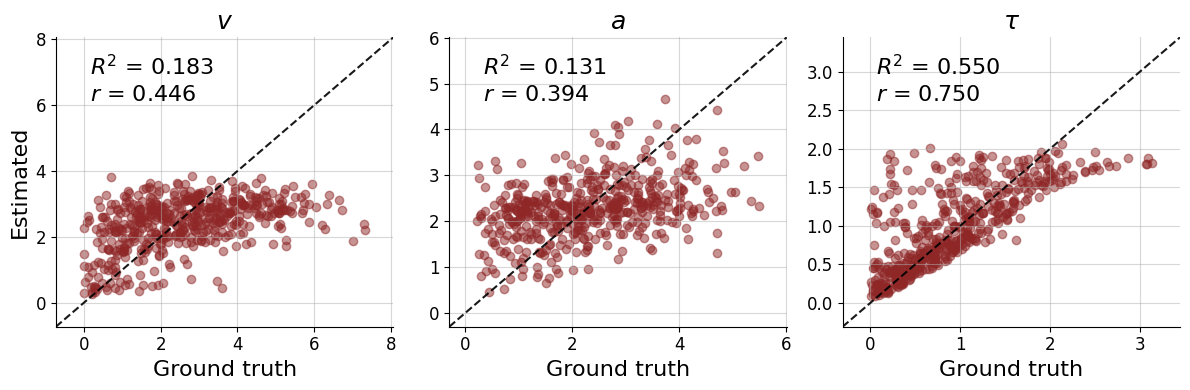

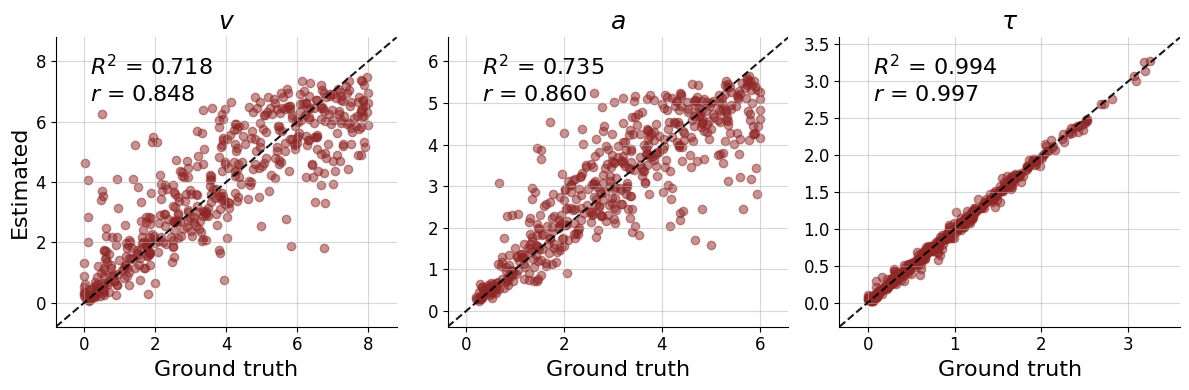

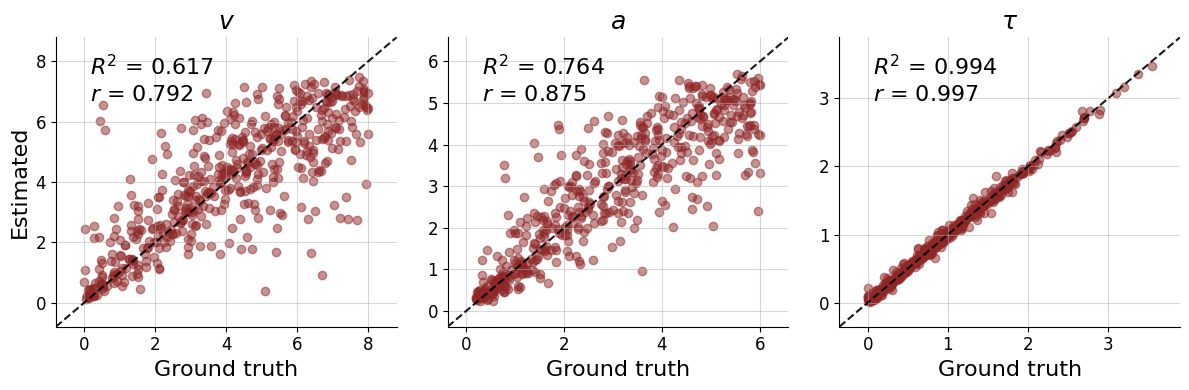

In [48]:
fig = plt.figure(constrained_layout=True, figsize=(10, 12))
# create 5x1 subfigs
subfigs = fig.subfigures(nrows=3, ncols=1)
for row, subfig in enumerate(subfigs):
    subfig.suptitle(f'T = {time_steps[row]}', fontsize=FONT_SIZE_1, fontweight='bold')
    axs = beef.diagnostics.plot_recovery(
        filtering_post_local_params_not_z[:, time_steps[row]],
        true_local_params[:, time_steps[row]],
        uncertainty_agg=None,
        param_names=LOCAL_PARAM_NAMES
        )

### R2 Scores over Time

In [59]:
smoothing_est = np.median(smoothing_post_local_params_not_z, axis=2)
filtering_est = np.median(filtering_post_local_params_not_z, axis=2)

In [101]:
r2_scores = np.zeros((2, NUM_OBS, 3))
for t in range(NUM_OBS):
    for p in range(3):
        r2_scores[0, t, p] = r2_score(true_local_params[:, t, p], smoothing_est[:, t, p])
        if t == 3:
            r2_scores[1, t, p] = np.nan
        else:
            r2_scores[1, t, p] = r2_score(true_local_params[:, t, p], filtering_est[:, t, p])

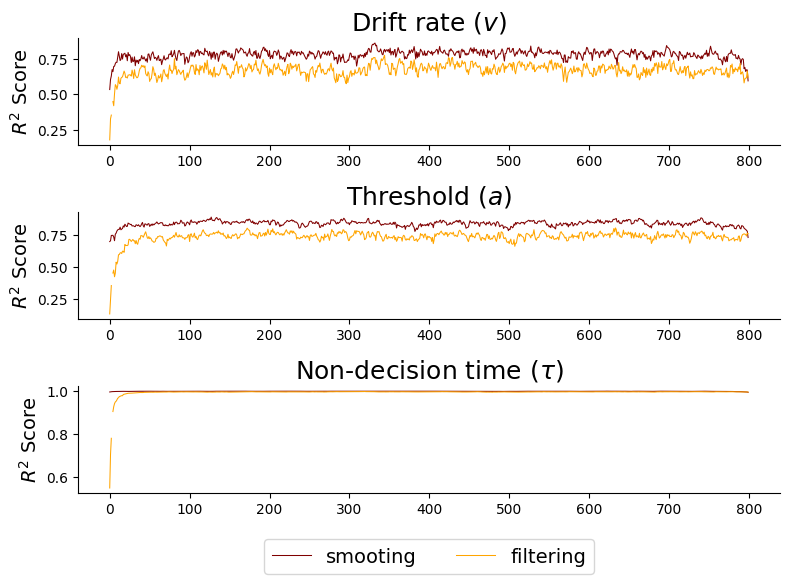

In [133]:
fig, axarr = plt.subplots(3, 1, figsize=(8, 6))
for i, ax in enumerate(axarr.flat):
    ax.plot(range(NUM_OBS), r2_scores[0, : , i], linewidth=0.75, color='maroon', label="smooting")
    ax.plot(range(NUM_OBS), r2_scores[1, : , i], linewidth=0.75, color='orange', label="filtering")
    ax.set_title(f'{MICRO_PARAM_LABELS[i]} ({MICRO_PARAM_NAMES[i]})', fontsize=FONT_SIZE_1)
    if i == 2:
        plt.subplots_adjust(hspace=0.5)
        plt.legend(fontsize=FONT_SIZE_3, loc='center', 
                bbox_to_anchor=(0.5, -0.6), ncol=2)
    ax.set_ylabel(r"$R^2$ Score", fontsize=FONT_SIZE_3)
sns.despine()
fig.tight_layout()

### Exemplar Parameter Trajectory

In [34]:
smoothing_post_local_params_not_z.shape

(500, 800, 1000, 3)

In [36]:
# smoothing_post_medians = np.median(smoothing_post_local_params_not_z, axis=2)
# filtering_post_medians = np.median(filtering_post_local_params_not_z, axis=2)
quantile_smoothing_post = np.quantile(smoothing_post_local_params_not_z, [0.025, 0.5, 0.975], axis=2)
quantile_filtering_post = np.quantile(filtering_post_local_params_not_z, [0.025, 0.5, 0.975], axis=2)

In [ ]:
quantile_smoothing_post.shape

In [ ]:
true_local_params.shape

In [ ]:
which = 0
fig, axarr = plt.subplots(3, 1, figsize=(8, 6))
for i, ax in enumerate(axarr.flat):
    ax.plot(
        range(NUM_OBS), quantile_smoothing_post_medians[1, :, i],
        linewidth=0.75, color='maroon', label="smooting", alpha=0.9
    )
    ax.fill_between(
        range(NUM_OBS),
        quantile_smoothing_post_medians[0, :, i],
        quantile_smoothing_post_medians[2, :, i],
        color='maroon', label="smooting", alpha=0.2
    )
    ax.plot(
        range(NUM_OBS), quantile_filtering_post_medians[1, :, i],
        linewidth=0.75, color='orange', label="filtering", alpha=0.9
    )
    ax.fill_between(
        range(NUM_OBS),
        quantile_filtering_post_medians[0, :, i],
        quantile_filtering_medians[2, :, i],
        color='maroon', label="smooting", alpha=0.2
    )
    ax.plot(
        range(NUM_OBS), true_local_params[1, :, i],
        linewidth=0.75, color='orange', label="filtering", alpha=0.9
    )

    ax.set_title(f'{MICRO_PARAM_LABELS[i]} ({MICRO_PARAM_NAMES[i]})', fontsize=FONT_SIZE_1)
    if i == 2:
        plt.subplots_adjust(hspace=0.5)
        plt.legend(fontsize=FONT_SIZE_3, loc='center', 
                bbox_to_anchor=(0.5, -0.7), ncol=2)
        ax.set_xlabel("Time step", fontsize=FONT_SIZE_3)
    ax.set_ylabel("Calibration error", fontsize=FONT_SIZE_3)
sns.despine()
fig.tight_layout()

## Posterior Contraction

In [135]:
smoothing_post_stds = smoothing_post_local_params_not_z.std(axis=2)
filtering_post_stds = filtering_post_local_params_not_z.std(axis=2)

quantile_smoothing_post_stds = np.quantile(smoothing_post_stds, [0.025, 0.5, 0.975], axis=0)
quantile_filtering_post_stds = np.quantile(filtering_post_stds, [0.025, 0.5, 0.975], axis=0)

(500, 800, 3)

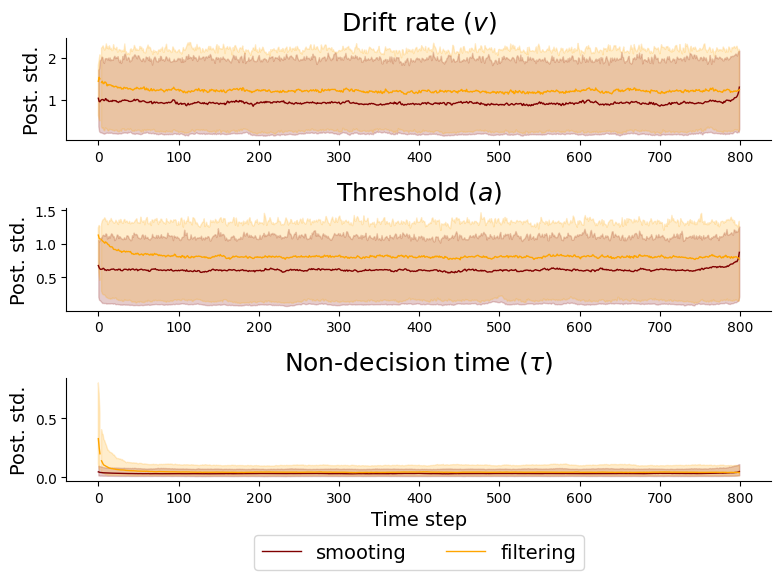

In [148]:
fig, axarr = plt.subplots(3, 1, figsize=(8, 6))
for i, ax in enumerate(axarr.flat):
    ax.plot(range(NUM_OBS), quantile_smoothing_post_stds[1, : , i], linewidth=1, color='maroon', label="smooting")
    ax.fill_between(
        range(NUM_OBS),
        quantile_smoothing_post_stds[0, : , i],
        quantile_smoothing_post_stds[2, : , i],
        color='maroon',
        alpha=0.2)

    ax.plot(range(NUM_OBS), quantile_filtering_post_stds[1, : , i], linewidth=1, color='orange', label="filtering")
    ax.fill_between(
        range(NUM_OBS),
        quantile_filtering_post_stds[0, : , i],
        quantile_filtering_post_stds[2, : , i],
        color='orange',
        alpha=0.2)

    ax.set_title(f'{MICRO_PARAM_LABELS[i]} ({MICRO_PARAM_NAMES[i]})', fontsize=FONT_SIZE_1)
    if i == 2:
        plt.subplots_adjust(hspace=0.5)
        plt.legend(fontsize=FONT_SIZE_3, loc='center', 
                bbox_to_anchor=(0.5, -0.7), ncol=2)
        ax.set_xlabel("Time step", fontsize=FONT_SIZE_3)
    ax.set_ylabel("Post. std.", fontsize=FONT_SIZE_3)
sns.despine()
fig.tight_layout()

## Calibration Hyperparameter

In [4]:
def posterior_calibration_error(
    posterior_samples,
    prior_samples,
    alpha_resolution=20,
    aggregator_fun=np.median,
    min_quantile=0.005,
    max_quantile=0.995,
):
    """Computes an aggregate score for the marginal calibration error over an ensemble of approximate
    posteriors. The calibration error is given as the aggregate (e.g., median) of the absolute deviation
    between an alpha-CI and the relative number of inliers from ``prior_samples`` over multiple alphas in
    (0, 1).

    Note: The function will use posterior quantiles for determining the credibility intervals. An alternative
    definition of the calibration error is possible using highest density intervals (HDIs).

    Parameters
    ----------
    posterior_samples  : np.ndarray of shape (num_datasets, num_draws, num_params)
        The random draws from the approximate posteriors over ``num_datasets``
    prior_samples      : np.ndarray of shape (num_datasets, num_params)
        The corresponding ground-truth values sampled from the prior
    alpha_resolution   : int, optional, default: 100
        The number of credibility intervals (CIs) to consider
    aggregator_fun     : callable or None, optional, default: np.median
        The function used to aggregate the marginal calibration errors.
        If ``None`` provided, the per-alpha calibration errors will be returned.
    min_quantile       : float in (0, 1), optional, default: 0.005
        The minimum posterior quantile to consider
    max_quantile       : float in (0, 1), optional, default: 0.995
        The maximum posterior quantile to consider

    Returns:
    --------
    calibration_errors : np.ndarray of shape (num_params, ) or (alpha_resolution, num_params),
        if ``aggregator_fun is None``.
        The aggregated calibration error per marginal posterior.
    """

    num_params = prior_samples.shape[1]
    alphas = np.linspace(min_quantile, max_quantile, alpha_resolution)
    absolute_errors = np.zeros((alpha_resolution, num_params))

    for i, alpha in enumerate(alphas):
        # Find lower and upper bounds of posterior distribution
        region = 1 - alpha
        lower = region / 2
        upper = 1 - (region / 2)

        # Compute percentiles for given alpha using the entire posterior sample
        quantiles = np.quantile(posterior_samples, [lower, upper], axis=1)

        # Compute the relative number of inliers
        higher_mask = quantiles[0] <= prior_samples
        lower_mask = prior_samples <= quantiles[1]
        inlier_id = np.logical_and(higher_mask, lower_mask)
        alpha_pred = np.mean(inlier_id, axis=0)
        absolute_errors[i] = np.abs(alpha_pred - alpha)

    if aggregator_fun is not None:
        calibration_errors = aggregator_fun(absolute_errors, axis=0)
        return calibration_errors
    return absolute_errors

In [9]:
if FIT_SBC:
    sbc_data = model.generate(NUM_SBC_SIMULATIONS)
    sbc_smoothing_post_hyper_params = np.zeros((NUM_SBC_SIMULATIONS, NUM_SBC_SAMPLES, 5))
    sbc_smoothing_post_local_params = np.zeros((NUM_SBC_SIMULATIONS, NUM_OBS, NUM_SBC_SAMPLES, 3))
    sbc_filtering_post_hyper_params = np.zeros((NUM_SBC_SIMULATIONS, NUM_SBC_SAMPLES, 5))
    sbc_filtering_post_local_params = np.zeros((NUM_SBC_SIMULATIONS, NUM_OBS, NUM_SBC_SAMPLES, 3))
    configured_sbc_data = model.configure(sbc_data)['summary_conditions']
    for i in range(NUM_SBC_SIMULATIONS):
        # fit smoothing network
        sbc_smoothing_post_samples = smoothing_experiment.amortizer.sample(
            {'summary_conditions': configured_sbc_data[i:i+1]},
            NUM_SBC_SAMPLES
            )
        sbc_smoothing_post_hyper_params[i] = smoothing_post_samples['global_samples']
        sbc_smoothing_post_local_params[i] = smoothing_post_samples['local_samples']
        # fit filtering network
        sbc_filtering_post_samples = filtering_experiment.amortizer.sample(
            {'summary_conditions': configured_sbc_data[i:i+1]},
            NUM_SBC_SAMPLES
            )
        sbc_filtering_post_hyper_params[i] = filtering_post_samples['global_samples']
        sbc_filtering_post_local_params[i] = filtering_post_samples['local_samples']

    with open('../data/sbc_data.pkl', 'wb') as f:
        pickle.dump(sbc_data, f)
    with open('../data/sbc_smoothing_post_hyper_params.pkl', 'wb') as f:
        pickle.dump(sbc_smoothing_post_hyper_params, f)
    with open('../data/sbc_smoothing_post_local_params.pkl', 'wb') as f:
        pickle.dump(sbc_smoothing_post_local_params, f)
    with open('../data/sbc_filtering_post_hyper_params.pkl', 'wb') as f:
        pickle.dump(sbc_filtering_post_hyper_params, f)
    with open('../data/sbc_filtering_post_local_params.pkl', 'wb') as f:
        pickle.dump(sbc_filtering_post_local_params, f)
else:
    with open('../data/sbc_data.pkl', 'wb') as f:
        pickle.dump(sbc_data, f)
    with open('../data/sbc_smoothing_post_hyper_params.pkl', 'rb') as f:
        sbc_smoothing_post_hyper_params = pickle.load(f)
    with open('../data/sbc_smoothing_post_local_params.pkl', 'rb') as f:
        sbc_smoothing_post_local_params = pickle.load(f)
    with open('../data/sbc_filtering_post_hyper_params.pkl', 'rb') as f:
        sbc_filtering_post_hyper_params = pickle.load(f)
    with open('../data/sbc_filtering_post_local_params.pkl', 'rb') as f:
        sbc_filtering_post_local_params = pickle.load(f)

In [14]:
sbc_true_hyper_params = sbc_data['hyper_prior_draws']
sbc_true_local_params = sbc_data['local_prior_draws']

In [18]:
sbc_smoothing_post_hyper_params_not_z = sbc_smoothing_post_hyper_params  * model.hyper_prior_std + model.hyper_prior_mean
sbc_filtering_post_hyper_params_not_z = sbc_filtering_post_hyper_params  * model.hyper_prior_std + model.hyper_prior_mean

### Smoothing

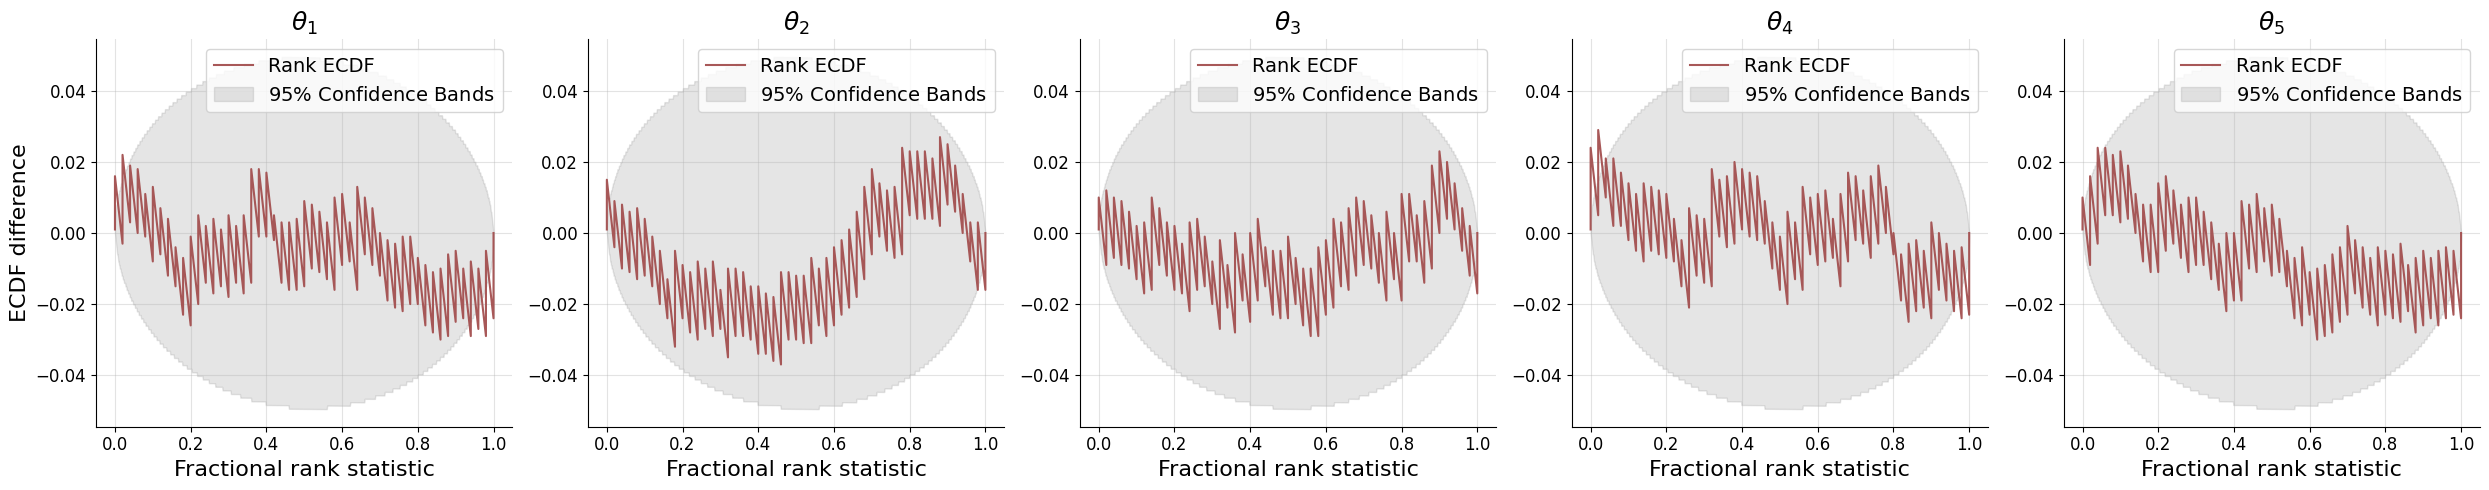

In [17]:
f = beef.diagnostics.plot_sbc_ecdf(
        sbc_smoothing_post_hyper_params_not_z,
        sbc_true_hyper_params,
        difference=True 
        )

### Filtering

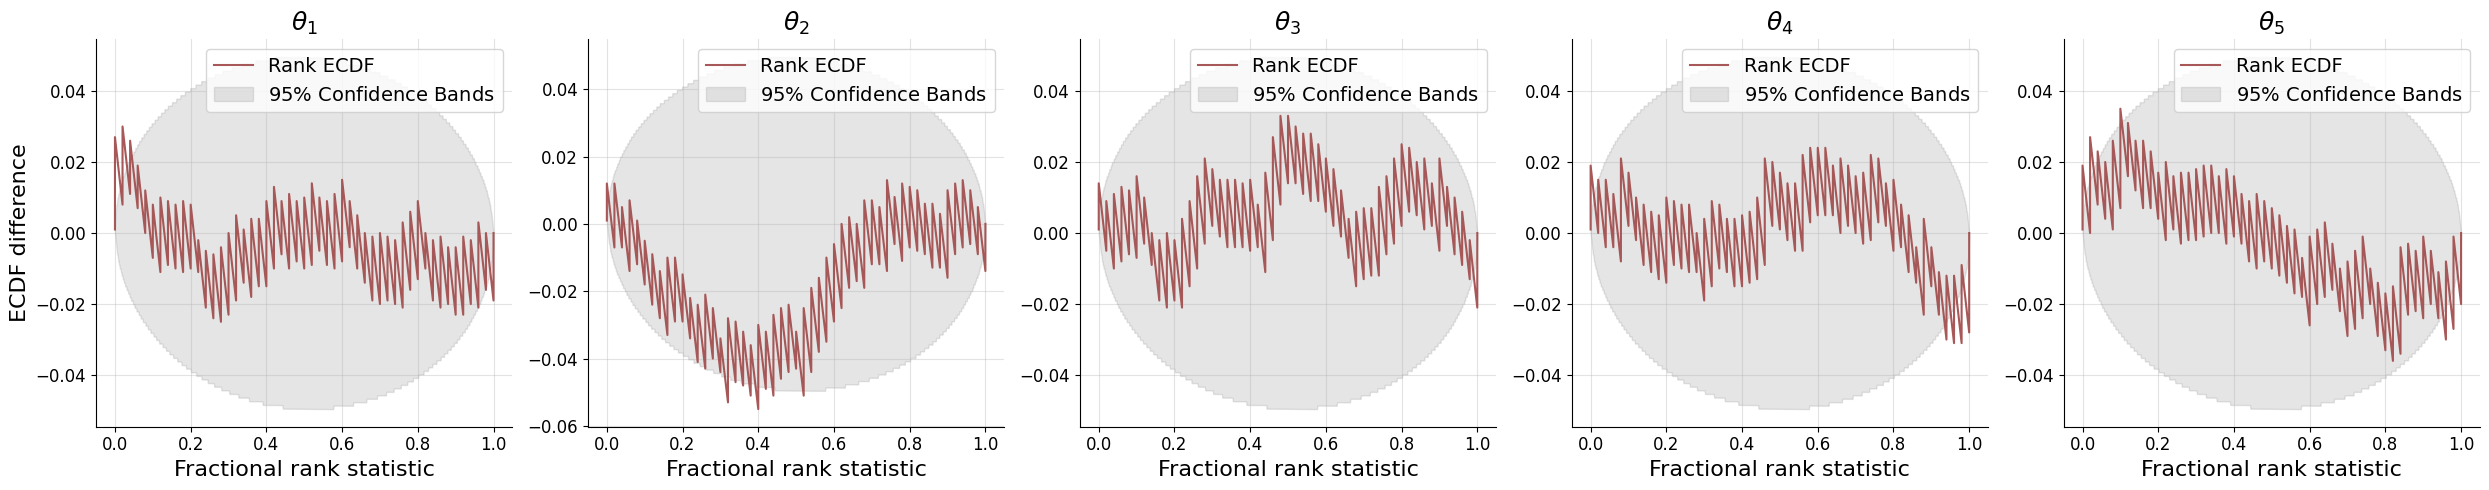

In [19]:
f = beef.diagnostics.plot_sbc_ecdf(
        sbc_filtering_post_hyper_params_not_z,
        sbc_true_hyper_params,
        difference=True 
        )

## Calibration Error over Time of Local Parameters

In [21]:
sbc_smoothing_post_local_params_not_z = sbc_smoothing_post_local_params  * model.local_prior_stds + model.local_prior_means
sbc_filtering_post_local_params_not_z = sbc_filtering_post_local_params  * model.local_prior_stds + model.local_prior_means

In [25]:
smoothing_local_calibration_error = np.zeros((NUM_OBS, 3))
filtering_local_calibration_error = np.zeros((NUM_OBS, 3))
for i in range(NUM_OBS):
    smoothing_local_calibration_error[i] = posterior_calibration_error(
        sbc_smoothing_post_local_params_not_z[:, i, :, :],
        sbc_true_local_params[:, i, :]
    )
    filtering_local_calibration_error[i] = posterior_calibration_error(
        sbc_filtering_post_local_params_not_z[:, i, :, :],
        sbc_true_local_params[:, i, :]
    )

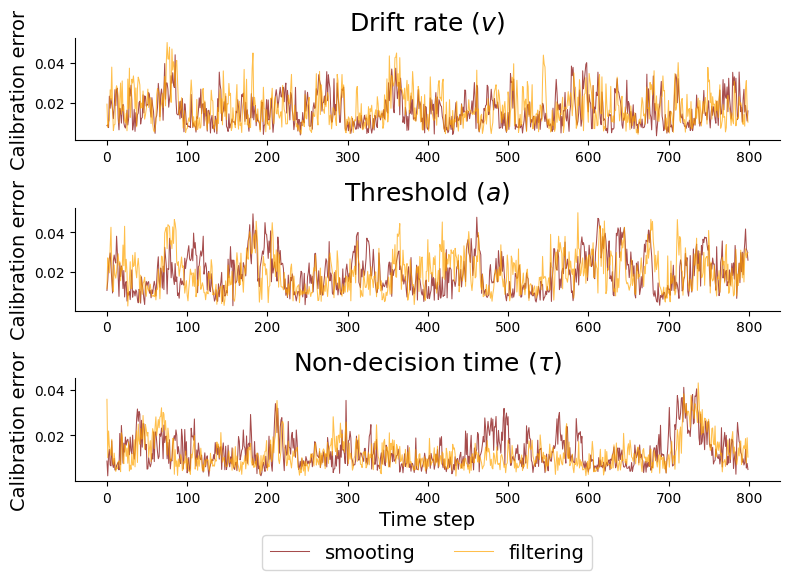

In [27]:
fig, axarr = plt.subplots(3, 1, figsize=(8, 6))
for i, ax in enumerate(axarr.flat):
    ax.plot(
        range(NUM_OBS), smoothing_local_calibration_error[:, i],
        linewidth=0.75, color='maroon', label="smooting", alpha=0.7
    )
    ax.plot(
        range(NUM_OBS), filtering_local_calibration_error[:, i],
        linewidth=0.75, color='orange', label="filtering", alpha=0.7
    )

    ax.set_title(f'{MICRO_PARAM_LABELS[i]} ({MICRO_PARAM_NAMES[i]})', fontsize=FONT_SIZE_1)
    if i == 2:
        plt.subplots_adjust(hspace=0.5)
        plt.legend(fontsize=FONT_SIZE_3, loc='center', 
                bbox_to_anchor=(0.5, -0.7), ncol=2)
        ax.set_xlabel("Time step", fontsize=FONT_SIZE_3)
    ax.set_ylabel("Calibration error", fontsize=FONT_SIZE_3)
sns.despine()
fig.tight_layout()